Simulating Spectra and Lightcurves with BATSE data
--------------------------------------------------

This example shows how to use a BATSE detector response file and some real BATSE background data to create a simulated source spectrum and a simulated source lightcurve.  This example uses concepts first introduced, and explained, in the **SwiftBatLightcurves** example.

---

First, we import the [`BatseRsp`](https://astro-gdt-cgro.readthedocs.io/en/latest/api/gdt.missions.cgro.batse.response.BatseRsp.html) class, which is the interface to the detector response file, and then we utilize it to open a file.  Once we open the file, we can print the handle to see some basic information about the response contained in the file.

In [1]:
from gdt.missions.cgro.batse.response import BatseRsp

rsp = BatseRsp.open('data/cont_drm_7_105.fits.gz')
print(rsp)

<BatseRsp: cont_drm_7_105.fits.gz;
 trigger time: 8367.384765717592;
 time range (-0.0013985185178171378, 0.0004503472227952443);
 62 energy bins; 16 channels>


We can plot the response to see what it looks like, and we do this by importing the [`ResponsePlot`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.plot.drm.ResponsePlot.html) class from the gdt-core package. 
This class plots the response Detector Response Matrix (DRM), and the DRM is generated for a larger energy range than what the BATSE instrument actually covers, so we zoom in and only show the response from 20 keV to 2 MeV.

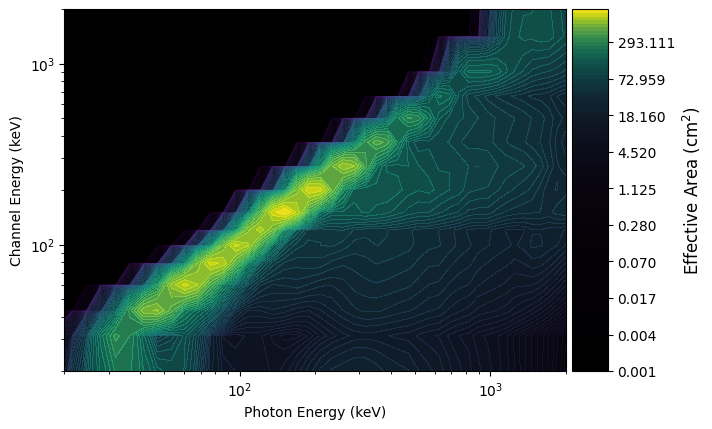

In [2]:
from gdt.core.plot.drm import ResponsePlot

drmplot = ResponsePlot(rsp.drm)
drmplot.xlim = (20.0, 2000.0)
drmplot.ylim = (20.0, 2000.0)

Once plotted, we see that the X axis is the incident photon energy and the Y axis is the detected channel energy.  The bright diagonal line is known as the photopeak, but there is also significant energy dispersion for a given incident energy into a range of channel energies. The DRM is needed to generate the spectral simulation of a source.  Basically, the source spectrum is folded through the response along the input photon energy side and will result in an array of counts observed over the range of energy channels.

The other piece that we need for simulations is a background.  Modeling and simulating the background spectrum of wide field hard X-ray and gamma-ray instruments can be quite difficult, but the GDT allows you to easily simulate background extracted from real BATSE data.  As an example, let us read a Continuous data file that contains one of the first Gamma-ray Burst detections of the mission.  To read this data, we import the [`BatsePhaiiTrigger`](https://astro-gdt-cgro.readthedocs.io/en/latest/api/gdt.missions.cgro.batse.phaii.BatsePhaiiTrigger.html) class and open the data file.  We can then plot the lightcurve using the [`Lightcurve`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.plot.lightcurve.Lightcurve.html) class.  In order to simulate a background spectrum, we need to fit the time-varying background in each channel, and select a segment of the background model to serve as the background for our spectral simulations.  The concepts for plotting the lightcurve and background fitting are explained in the **SwiftBatLightcurves** example, and the lightcurve and background model is shown here.

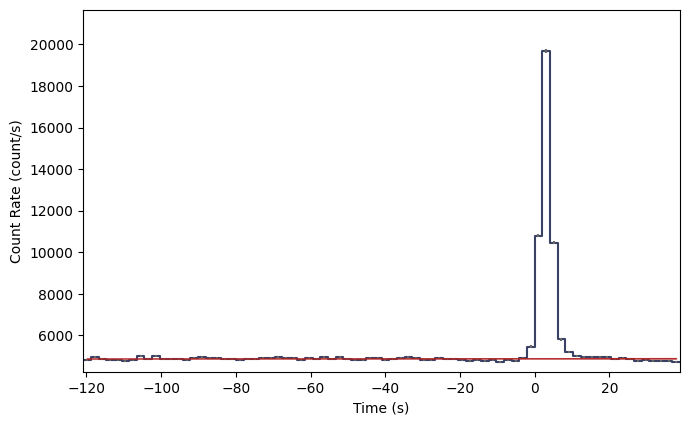

In [3]:
from gdt.missions.cgro.batse.phaii import BatsePhaiiTrigger
from gdt.core.background.fitter import BackgroundFitter
from gdt.core.background.binned import Polynomial
from gdt.core.plot.lightcurve import Lightcurve

phaii = BatsePhaiiTrigger.open('data/cont_bfits_7_105.fits.gz')

# range over which to fit background
back_time = (-120.0, -20.0)

# fit 1st order polynomial
fitter = BackgroundFitter.from_phaii(phaii, Polynomial, [back_time])
fitter.fit(order=1)
back_model = fitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)

lcplot = Lightcurve(phaii.to_lightcurve(), background=back_model)

The lightcurve (blue) and background model (red) are shown in the plot.  The background appears to be a good fit prior to the signal.  We should also check the count spectrum to make sure that the background fit is accurate for each channel.  We do this by integrating over some time range of the background (-120 to -20 seconds in this example) and we use the [`Spectrum`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.plot.spectrum.Spectrum.html) class to plot.

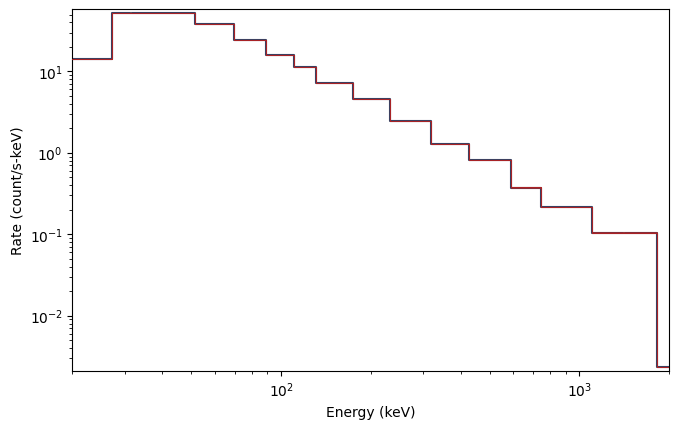

In [4]:
from gdt.core.plot.spectrum import Spectrum

# integrate over the background time range to get the spectrum
back_spec = back_model.integrate_time(*back_time)
data_spec = phaii.to_spectrum(time_range=back_time)

specplot = Spectrum(data_spec, background=back_spec)
specplot.xlim = (20.0, 2000.0)

Here the plotted count spectrum of the data (blue) and the background model (red) are almost perfectly aligned, which means that we have a good background model.

Now that we have a background model and a detector response, the next step is to fold a source spectrum through the response.  In this example, we will use the initial spectrum of the famous GRB 170817A, a binary neutron star merger.  The initial spectrum lasted a bit longer than half a second, and was best described with a Comptonized function--a power law with an exponential cut off.  The [`Comptonized`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.spectra.functions.Comptonized.html) spectral function is imported from the GDT, and we also import the [`PhaSimulator`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.simulate.pha.PhaSimulator.html) class, which will simulate the source+background count spectrum.  We initialize PhaSimulator with the detector response, the spectral function and parameters, the exposure, and our background spectrum.

In [5]:
from gdt.core.spectra.functions import Comptonized
from gdt.core.simulate import PhaSimulator

exposure = 0.58
# amplitude, epeak, index
comp_params = (0.013, 185.0, -0.6)

# background is simulated assuming a Gaussian distribution
pha_sims = PhaSimulator(rsp, Comptonized(), comp_params, exposure, back_spec, 'Gaussian')

Now that the simulator is initialized, we can generate simulated realizations of the background and background+source spectra.  We will use the the [`SpectrumBackground`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.plot.plot.SpectrumBackground.html) and [`Histo`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.plot.plot.Histo.html) plotting classes to plot the respective spectral realizations.

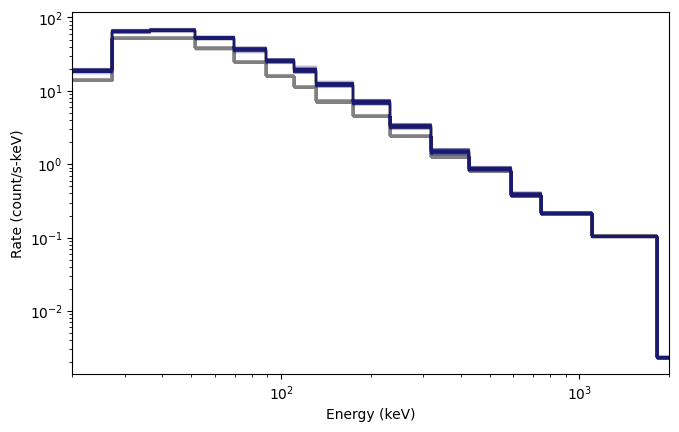

In [6]:
from gdt.core.plot.plot import SpectrumBackground, Histo

# 100 realizations of the background
back_devs = pha_sims.simulate_background(100)

# 100 realizations of source+background
summed_devs = pha_sims.simulate_sum(100)

specplot = Spectrum()
specplot.xlim = (20.0, 2000.0)

# background from each simulation
back_sims = [SpectrumBackground(back_dev, specplot.ax, color='gray', alpha=0.1) for back_dev in back_devs]
# the summed "observed" data from each simulation
signal_sims = [Histo(summed_dev, specplot.ax, color='midnightblue', alpha=0.1) for summed_dev in summed_devs]

Here we have the background realizations plotted in gray and the total (source+background) in blue.  The thickness of bars in the distribution is a result of the Poisson variance of the source and the Gaussian variance of the background.  The excess in total counts above background from ~20-400 keV indicates that there should be observable signal above background in that energy range.

In addition to simulating a spectrum, we can create a temporal-spectral simulation where the time-series spectrum is amplitude-modulated by a lightcurve profile.  To do this, we use the [`TteSourceSimulator`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.simulate.tte.TteSourceSimulator.html) and [`TteBackgroundSimulator`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.simulate.tte.TteBackgroundSimulator.html), which will create simulated event data.  For the lightcurve, we will use a [`norris`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.simulate.profiles.norris.html) pulse profile and a [`constant`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.simulate.profiles.constant.html#gdt.core.simulate.profiles.constant) background.  In these simulations, the spectrum stays the same, but its amplitude is modulated by the lightcurve profile. Similarly, the background spectrum amplitude is modulated by the background profile (for the constant background, a value of 1.0 indicates an amplitude that is the same as the modeled background).

In [7]:
from gdt.core.simulate import TteSourceSimulator, TteBackgroundSimulator
from gdt.core.simulate.profiles import norris, constant

# pulse shape parameters
norris_params = (0.025, 0.0, 0.1, 0.2)

# constant background (1.0x the background spectrum)
constant_params = (1.0,)

For the source simulations, we initialize `TteSourceSimulator` with the detector response, spectral function and parameters, and lightcurve function and parameters.  We can then call `to_tte()` to generate event data for a single source realization.

In [8]:
# initialize simulator with the spectral model and time profile
tte_sim = TteSourceSimulator(rsp, Comptonized(), comp_params, norris, norris_params)

# simulate the source over a time range of (T0-5.0, T0+5.0) s
tte_src = tte_sim.to_tte(-5.0, 5.0)

Then we similarly initialize `TteBackgroundSimulator` with the background spectrum, the choice of Poisson or Gaussian statistics, and the background function and parameters. As with the source simulation, `to_tte()` generates the event data for a single realization of the background.

In [9]:
# use our background model spectrum and keep scale at 100% of the background amplitude
tte_sim = TteBackgroundSimulator(back_spec, 'Gaussian', constant, constant_params)

# simulate the background over a time range of (T0-10.0, T0+10.0) s
tte_bkgd = tte_sim.to_tte(-10.0, 10.0)

We have two event lists: one for background and one for the source.  We can simply merge the two lists together with [`PhotonList`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.tte.PhotonList.html) to create the final event list.  Finally, we can plot the lightcurve by binning the event data to 64 ms resolution using the [`bin_by_time`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.binning.unbinned.bin_by_time.html) method.

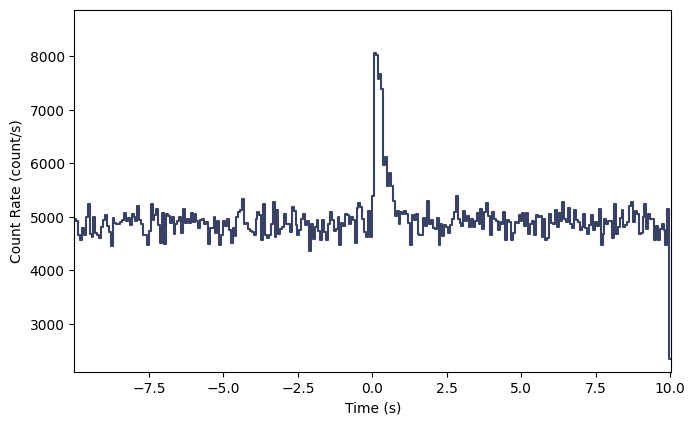

In [10]:
from gdt.core.tte import PhotonList
from gdt.core.binning.unbinned import bin_by_time

# merge the background and source
tte_total = PhotonList.merge([tte_bkgd, tte_src])

# bin to 64 ms resolution so we can make a lightcurve plot
phaii = tte_total.to_phaii(bin_by_time, 0.064)
lcplot = Lightcurve(phaii.to_lightcurve())
lcplot.errorbars.hide()